In [55]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

from scipy import signal
import numpy as np
from scipy.ndimage import zoom


import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import gc

In [56]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo valid'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
# rt = np.empty((0,))
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    _, sa, _, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        sham_after_slow = sa
        real_after_slow = ra
    else:
        sham_after_fast = sa
        real_after_fast = ra

sham_after_slow_aligned = align_slow(sham_after_slow, case_title, fs)
real_after_slow_aligned = align_slow(real_after_slow, case_title, fs)
data_after = []
label = []
for channel in range(len(sham_after_slow)):
    sham_after = np.vstack((sham_after_slow_aligned[channel], sham_after_fast[channel]))
    sham_number = sham_after.shape[0]
    real_after = np.vstack((real_after_slow_aligned[channel], real_after_fast[channel]))
    real_number = real_after.shape[0]
    data_after.append(np.vstack((sham_after, real_after)))
    this_channel_label = np.concatenate((np.zeros(sham_number), np.ones(real_number)))
    label.append(this_channel_label)

In [126]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
cycle_bands = [[3, 4], [4, 5], [5, 6], [6, 7]]

channel = 7
data_onechan = data_after[channel]
label_onechan = label[channel]
cwtms_onechan = np.empty((data_onechan.shape[0], len(freq_bands), 256, 256))
t = np.linspace(0, data_onechan.shape[1]/fs, data_onechan.shape[1])

for freq_th in range(len(freq_bands)):

    fmin, fmax = freq_bands[freq_th][0], freq_bands[freq_th][1]
    cycles_min, cycles_max = cycle_bands[freq_th][0], cycle_bands[freq_th][1]
    num_freqs = 256

    freq = np.logspace(np.log10(fmin), np.log10(fmax), num_freqs)
    cycles = np.logspace(np.log10(cycles_min), np.log10(cycles_max), num_freqs)
    widths = cycles * fs / (2 * freq * np.pi)

    for trial in range(data_onechan.shape[0]):
        one_trial = data_onechan[trial,:]
        cwtm_list = []
        for f_idx in range(len(freq)):
            cwtm_f = signal.cwt(one_trial, signal.morlet2, [widths[f_idx]], w=cycles[f_idx]).__abs__()
            cwtm_list.append(cwtm_f)
        cwtm_stacked = np.vstack(cwtm_list)
        cwtm_stacked = zoom(cwtm_stacked, (1, num_freqs/cwtm_stacked.shape[1]))
        cwtms_onechan[trial,freq_th,:,:] = cwtm_stacked

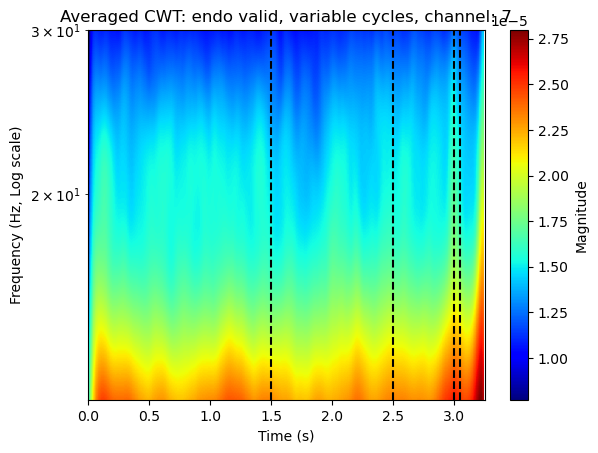

In [127]:
## see one plot
freq_th = 2
freq = np.array(freq_bands[freq_th])
cwtm = np.mean(cwtms_onechan[:,freq_th,:,:], axis=0)
plt.imshow(cwtm, origin='lower', aspect='auto', extent=[t.min(), t.max(), freq.min(), freq.max()], 
           cmap='jet')

if 'endo' in case_title:
    plt.axvline(1.5, color='k', linestyle='--')
    plt.axvline(1.5+1, color='k', linestyle='--')
    plt.axvline(1.5+1+0.5, color='k', linestyle='--')
    plt.axvline(1.5+1+0.5+0.05, color='k', linestyle='--')
else:
    plt.axvline(1.5, color='k', linestyle='--')
    plt.axvline(1.5+0.033*4, color='k', linestyle='--')
    plt.axvline(1.5+0.033*4+0.5, color='k', linestyle='--')
    plt.axvline(1.5+0.033*4+0.5+0.05, color='k', linestyle='--')

# plt.axhline(4, color='k', linestyle='--')
# plt.axhline(8, color='k', linestyle='--')
# plt.axhline(12, color='k', linestyle='--')
# plt.axhline(30, color='k', linestyle='--')

plt.yscale('log')
# plt.yscale('linear')
plt.colorbar(label='Magnitude')

# # Adjust the yticks for log scale
# yticks_values = [4, 8, 12, 30, 50]
# plt.gca().set_yticks(yticks_values)
# plt.gca().set_yticklabels(yticks_values)
# # Remove minor ticks
# plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('Frequency (Hz, Log scale)')
plt.xlabel('Time (s)')
plt.title('Averaged CWT: '+ case_title + ', variable cycles'+ ', channel: '+ str(channel))
plt.xlim(t.min(), t.max())
plt.ylim(freq.min(), freq.max())
plt.show()

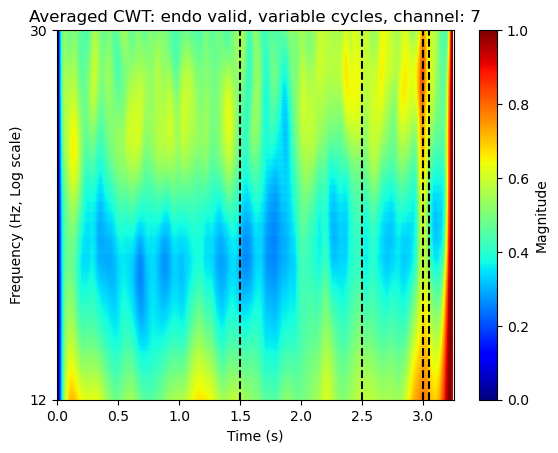

In [128]:
def normalize_by_row(mat):

    row_min = np.min(mat, axis=1)[:, np.newaxis]
    row_max = np.max(mat, axis=1)[:, np.newaxis]

    # Normalize the matrix
    normalized_mat = (mat - row_min) / (row_max - row_min)
    
    return normalized_mat

cwtm_normalized = normalize_by_row(cwtm)
plt.imshow(cwtm_normalized, origin='lower', aspect='auto', extent=[t.min(), t.max(), freq.min(), freq.max()], 
           cmap='jet')

if 'endo' in case_title:
    plt.axvline(1.5, color='k', linestyle='--')
    plt.axvline(1.5+1, color='k', linestyle='--')
    plt.axvline(1.5+1+0.5, color='k', linestyle='--')
    plt.axvline(1.5+1+0.5+0.05, color='k', linestyle='--')
else:
    plt.axvline(1.5, color='k', linestyle='--')
    plt.axvline(1.5+0.033*4, color='k', linestyle='--')
    plt.axvline(1.5+0.033*4+0.5, color='k', linestyle='--')
    plt.axvline(1.5+0.033*4+0.5+0.05, color='k', linestyle='--')

# plt.axhline(4, color='k', linestyle='--')
# plt.axhline(8, color='k', linestyle='--')
# plt.axhline(12, color='k', linestyle='--')
# plt.axhline(30, color='k', linestyle='--')

plt.yscale('log')
# plt.yscale('linear')
plt.colorbar(label='Magnitude')

# Adjust the yticks for log scale
yticks_values = [4, 8, 12, 30, 50]
plt.gca().set_yticks(yticks_values)
plt.gca().set_yticklabels(yticks_values)
# Remove minor ticks
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

plt.ylabel('Frequency (Hz, Log scale)')
plt.xlabel('Time (s)')
plt.title('Averaged CWT: '+ case_title + ', variable cycles'+ ', channel: '+ str(channel))
plt.xlim(t.min(), t.max())
plt.ylim(freq.min(), freq.max())
plt.show()

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert your data to PyTorch tensors
cwtm_tensor = torch.FloatTensor(cwtms_onechan[:,freq_th,:,:])
label_tensor = torch.FloatTensor(label_onechan)

# Create a dataset from your tensors
dataset = TensorDataset(cwtm_tensor.unsqueeze(1), label_tensor.long())  # Adding channel dimension

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define a CNN model with four convolutional layers
class FourLayerCNN(nn.Module):
    def __init__(self):
        super(FourLayerCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(256*16*16, 512)  # Adjust dimensions accordingly
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.relu_fc1(out)
        out = self.fc2(out)
        return out

# Instantiate the model, define the loss function and the optimizer
model = FourLayerCNN().to('cuda')  # Assuming GPU is available
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Assuming GPU is available
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')  # Assuming GPU is available
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy on the validation set: {accuracy}%')


Epoch 1/100, Loss: 0.6944952692304339
Epoch 2/100, Loss: 0.693544172105335
Epoch 3/100, Loss: 0.693281888961792
Epoch 4/100, Loss: 0.6933116941224962
Epoch 5/100, Loss: 0.6936669207754589
Epoch 6/100, Loss: 0.6931327354340326
Epoch 7/100, Loss: 0.6932435858817327
Epoch 8/100, Loss: 0.6931714954830351
Epoch 9/100, Loss: 0.6931870210738409
Epoch 10/100, Loss: 0.6931709051132202
Epoch 11/100, Loss: 0.6931755400839306
Epoch 12/100, Loss: 0.6931587372507367
Epoch 13/100, Loss: 0.6931822158041454
Epoch 14/100, Loss: 0.6931930212747484
Epoch 15/100, Loss: 0.6931901744433812
Epoch 16/100, Loss: 0.6931757160595485
Epoch 17/100, Loss: 0.6931655946232024
Epoch 18/100, Loss: 0.6932333054996672
Epoch 19/100, Loss: 0.6931533274196443
Epoch 20/100, Loss: 0.6931552007084801
Epoch 21/100, Loss: 0.6931594752130055
Epoch 22/100, Loss: 0.6931627988815308
Epoch 23/100, Loss: 0.6931674111457098
Epoch 24/100, Loss: 0.6931667753628322
Epoch 25/100, Loss: 0.6931607893535069
Epoch 26/100, Loss: 0.69320752790996

In [130]:
freq_th = 1
# Convert your data to PyTorch tensors
cwtm_tensor = torch.FloatTensor(cwtms_onechan[:,freq_th,:,:])
label_tensor = torch.FloatTensor(label_onechan)

# Split the data into training and testing sets
X_train, X_tmp, y_train, y_tmp = train_test_split(cwtm_tensor, label_tensor, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

train_dataset = TensorDataset(X_train.unsqueeze(1), y_train)  # Add channel dimension
test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)     # Add channel dimension
valid_dataset = TensorDataset(X_valid.unsqueeze(1), y_valid) # Add channel dimension

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3), # 3,64=> 1,64
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 1) # originally (512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.fc(x)
        
        return x

In [132]:
num_classes = 2 # regression, originally=10
num_epochs = 20
batch_size = 32
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.0001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [133]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        # labels = labels.to(device)
        labels = labels.view(-1, 1).to(device)
        
        # Forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the validation images: {} %'.format(100 * correct / total)) 

Epoch [1/20], Loss: 0.6726
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [2/20], Loss: 1.1220
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [3/20], Loss: 3.8737
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [4/20], Loss: 0.6081
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [5/20], Loss: 0.6419
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [6/20], Loss: 0.5796
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [7/20], Loss: 0.6745
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [8/20], Loss: 0.6592
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [9/20], Loss: 0.6084
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [10/20], Loss: 0.6812
Accuracy of the network on the validation images: 55.95238095238095 %
Epoch [11/20], Loss: 0.5813
A

In [134]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        train_loss = loss.item()
            
    # Validation
    valid_loss = 0
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            del images, labels, outputs

    valid_loss /= len(valid_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))

In [ ]:
total_loss = 0
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        del images, labels, outputs

avg_loss = total_loss / len(test_loader)
print(f"Test Loss: {avg_loss:.4f}")
torch.cuda.empty_cache()

ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1]))

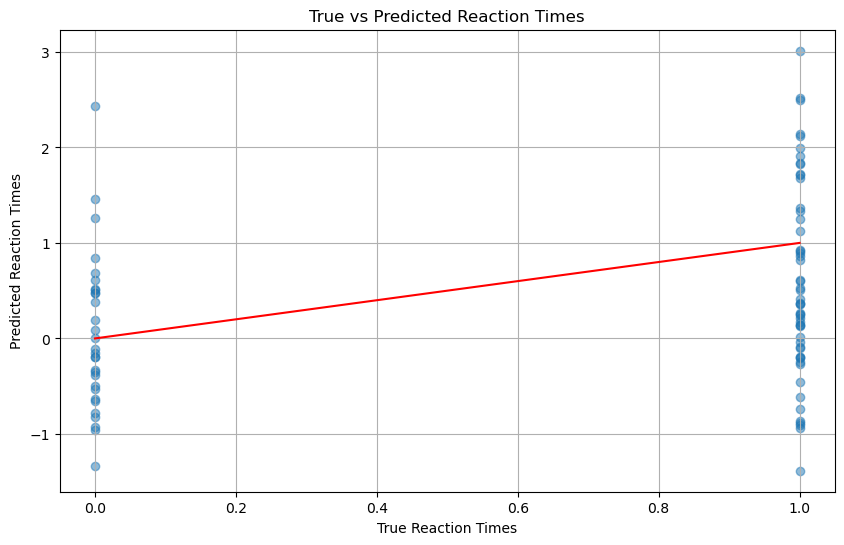

In [ ]:
all_targets = []
all_predictions = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        
        all_targets.extend(target.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_predictions, alpha=0.5)
plt.plot([min(all_targets), max(all_targets)], 
         [min(all_targets), max(all_targets)], 
         color='red')
plt.xlabel('True Reaction Times')
plt.ylabel('Predicted Reaction Times')
plt.title('True vs Predicted Reaction Times')
plt.grid(True)
plt.show()